
### Architecture
This experiment purpose is to apply GBDT on metadata without involving the images. A simple LightGBM is trained on metadata and final outputs are predicted for pawpularity
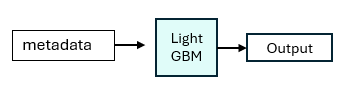

In [32]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [34]:
#  imports & setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
import lightgbm as lgb
import joblib

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config

main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
out_dir = os.path.join(main_folder, "outputs", "exp1")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp1"]
TARGET = "Pawpularity"
tab_cols = [c for c in df.columns if c not in ["Id", TARGET]]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])


In [35]:
#  KFold CV with LightGBM
n_splits = cfg["n_splits"]
seed = cfg["seed"]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
oof_pred = np.zeros(len(df))
fold_rmse = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\n=== {cfg['name']}: Fold {fold+1} (Tab-only LGBM) ===")

    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    X_tr = train_df[tab_cols]
    y_tr = train_df[TARGET].values
    X_val = val_df[tab_cols]
    y_val = val_df[TARGET].values

    model = lgb.LGBMRegressor(
        n_estimators=5000,
        learning_rate=0.01,
        num_leaves=128,
        max_depth=20,
        min_data_in_leaf=50,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=1,
        lambda_l1=0.1,
        lambda_l2=0.1,
        random_state=seed,
        metric="rmse",
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
    )
    preds = model.predict(X_val)
    oof_pred[val_idx] = preds
    rmse = root_mean_squared_error(y_val, preds)
    fold_rmse.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.4f}")

    joblib.dump(model, os.path.join(out_dir, f"lgbm_fold{fold+1}.pkl"))

oof_rmse = root_mean_squared_error(df[TARGET], oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"\nOOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "ytrue": df[TARGET],
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)

np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")



=== Exp1_TabOnly_LGBM: Fold 1 (Tab-only LGBM) ===
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be 

In [36]:
#  Inspect worst errors (show images)
errors_path = os.path.join(out_dir, "top50_errors.csv")
err_df = pd.read_csv(errors_path)
err_df.head()

Id  ytrue   oof_pred    abs_err
0  381760146525b4e79e00722eb674f7fe    100  27.847994  72.152006
1  bc7d2b3b519718202e05e1965a64bc5a    100  28.552418  71.447582
2  ad1362089c0b9e4a50ea15e2219c2907    100  28.850405  71.149595
3  21b202145a45db41ca275befaeb4530f    100  29.090425  70.909575
4  3fa409545d9c624436e83a8814ffacc6    100  29.651847  70.348153

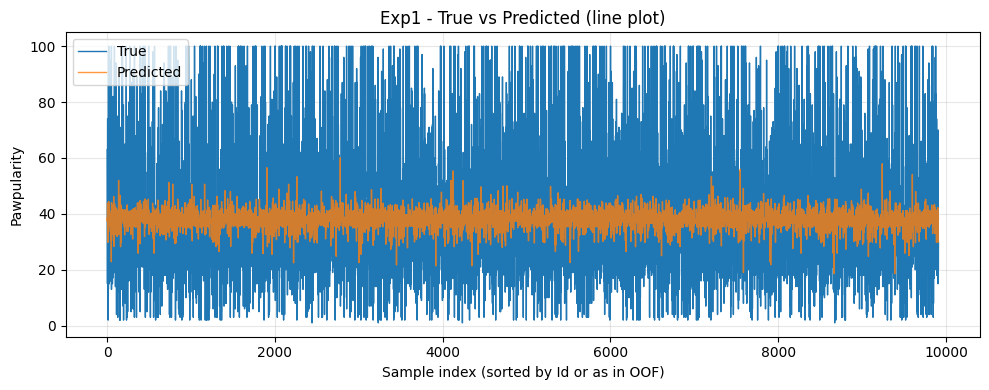

In [37]:
import os
import pandas as pd
from src.plot import (
   plot_oof_true_pred_lines,
    show_error_images_grid,
)

# Load OOF detail and top-errors
oof_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))
err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

# Plots
plot_oof_true_pred_lines(oof_df, title_prefix="Exp1")





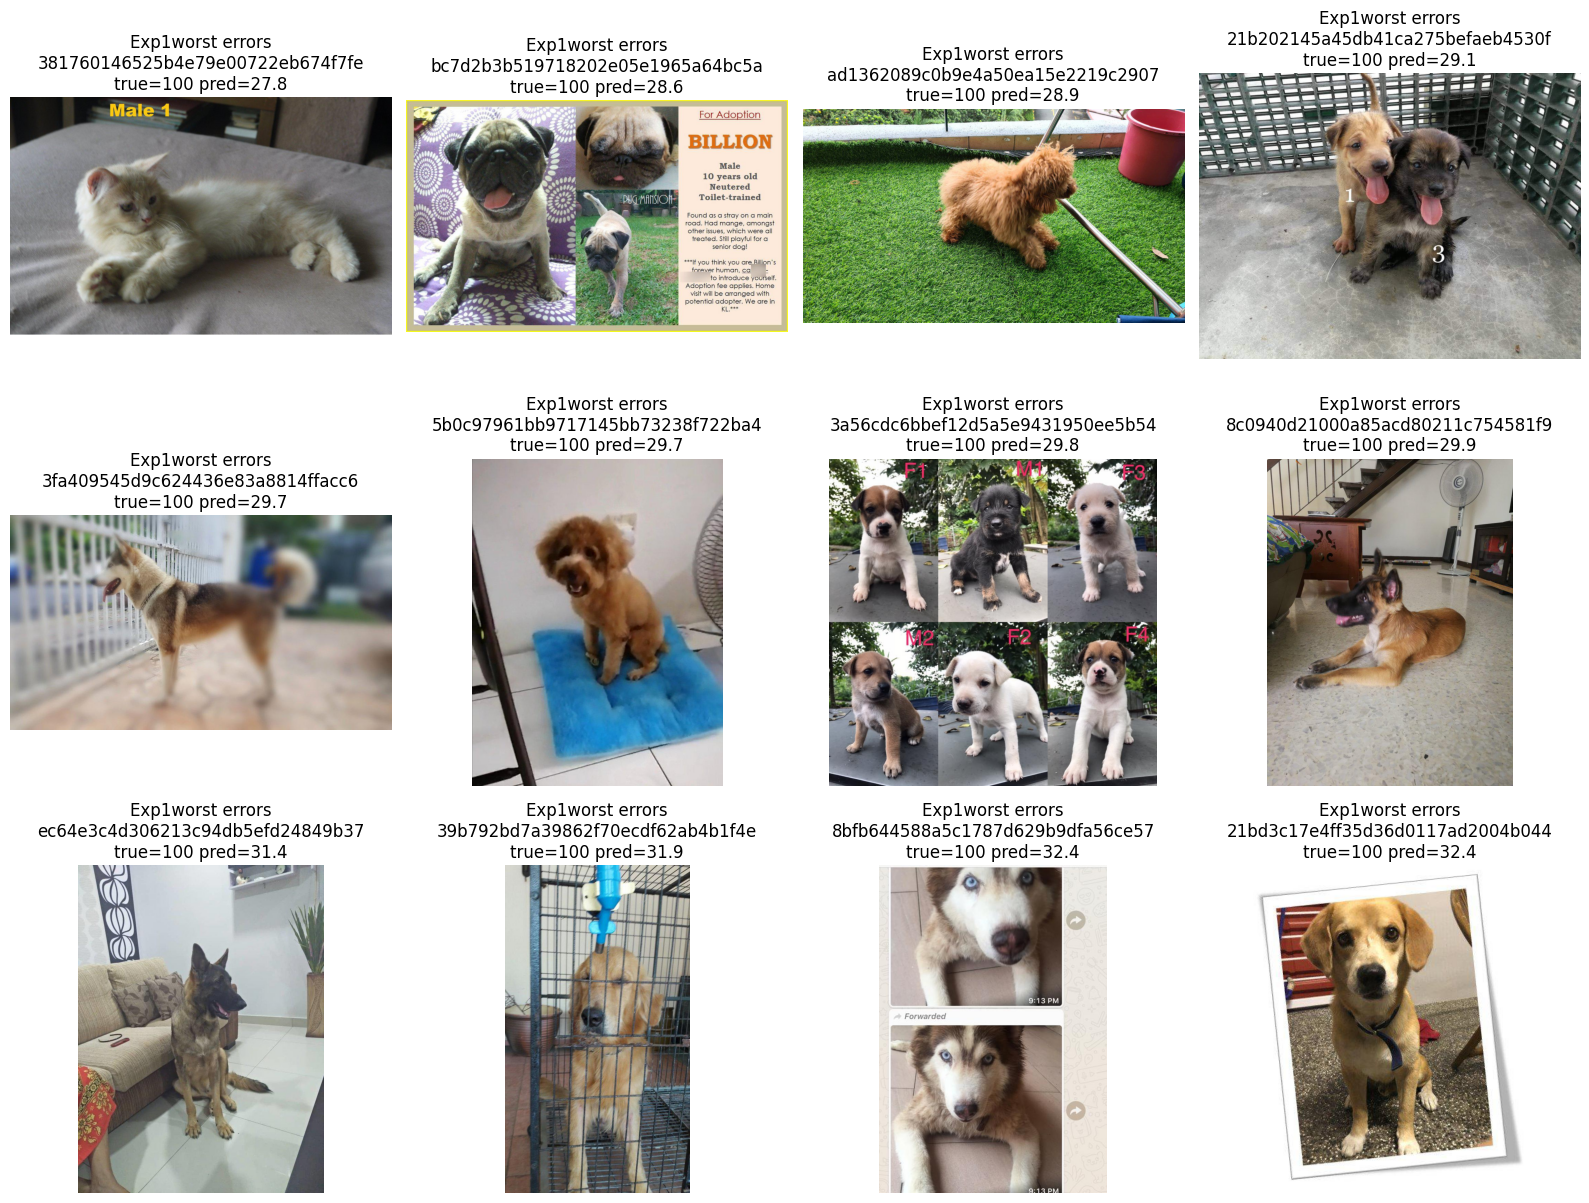

In [38]:
# Images of worst errors
img_folder = os.path.join(main_folder, "data", "train")
show_error_images_grid(err_df, img_folder, n=12, title_prefix="Exp1worst errors")